In [410]:
import pandas as pd
import re
import matplotlib.pyplot as plt

from string2string.alignment import LongestCommonSubsequence
from string2string.distance import JaccardIndex



In [411]:
generated = pd.read_csv("../data/generated_outputs.csv")
# generated = generated[temperatures].melt().rename({"variable": "temperature", "value": "text"}, axis=1)

In [412]:
original = pd.read_csv("../summaries.csv")

In [413]:
new = pd.read_csv("../data/processed_responses.csv").drop("HITId", axis=1)

In [414]:
qids = pd.read_csv("../data/qids.csv")

In [415]:
temperatures = [str(k) for k in [0.3, 0.5, 0.7, 0.9, 1]]

In [416]:
generated["texts"] = generated["texts"].apply(lambda x: x[4:20]).str.lower()
qids["question"] = qids["question"].apply(lambda x: x[4:20]).str.lower()

In [417]:
new["original_text"] = new["original_text"].apply(lambda x: x[4:20]).str.lower()

In [418]:
original = original[["Question", "Answer"]]

In [419]:
new = new.merge(qids, left_on="original_text", right_on="question")[["HITId","summary"]]

In [438]:
new = new[new["summary"].map(len) > 150]

In [440]:
generated = generated.merge(qids, left_on="texts", right_on="question")[["HITId"] + temperatures].melt(id_vars = "HITId").rename({"value":"generated"}, axis=1)

In [422]:
generated = generated[generated["variable"].str.contains("0.7|1")]

In [455]:
new

,HITId,summary
0,NEJMoa0804748,Because carbs usually provide over half of cal...
1,NEJMoa0804748,A study was conducted to compare the effective...
2,NEJMoa0804748,This two-year study found that diets varying i...
3,NEJMoa1000727,Effect of Screening Mammography on Breast-Canc...
4,NEJMoa1000727,A study in Norway found that screening mammogr...
5,NEJMoa1000727,The Norwegian breast-cancer screening program ...
6,NEJMoa1102287,Exciting news from a study on a malaria vaccin...
7,NEJMoa1102287,"A phase 3 study of the malaria vaccine RTS, S/..."
8,NEJMoa1102287,"A phase 3 trial of the RTS, S/AS01 malaria vac..."
9,NEJMoa1003833,Azithromycin is a broad-spectrum macrolide ant...


In [441]:
def extract_answer(text):
    pattern = r"<FreeText>(.*?)</FreeText>"
    matches = re.findall(pattern, text, re.DOTALL)

    return matches[1]
original["Answer"] = original["Answer"].apply(lambda x: extract_answer(x))

IndexError: list index out of range

In [442]:
def measure_subseq_length(gen, k):
#     lcsubsequence = LongestCommonSubstring()
    lcsubsequence = LongestCommonSubsequence()
    
    tokenizer = Tokenizer(word_delimiter=' ')

    gen_token = tokenizer.tokenize(gen)
    k_token = tokenizer.tokenize(k)
    
    
    length, candidates = lcsubsequence.compute(
        str1=gen_token,
        str2=k_token,
        returnCandidates=False,
    )
    return length 

In [ ]:
def measure_substr_length(gen, k):
    lcsubsequence = LongestCommonSubstring()
    
    tokenizer = Tokenizer(word_delimiter=' ')

    gen_token = tokenizer.tokenize(gen)
    k_token = tokenizer.tokenize(k)
    
    
    length, candidates = lcsubsequence.compute(
        str1=gen_token,
        str2=k_token,
        returnCandidates=False,
    )
    return length 

In [443]:
def measure_jaccard_sim(gen, k):
#     lcsubsequence = LongestCommonSubstring()
    jaccard_distance = JaccardIndex()
    
    tokenizer = Tokenizer(word_delimiter=' ')

    gen_token = tokenizer.tokenize(gen)
    k_token = tokenizer.tokenize(k)
    
    
    jaccard_dist_score = jaccard_distance.compute(gen_token, k_token)

    return jaccard_dist_score

In [444]:
ids = new["HITId"].unique()

In [445]:
new_sim = []
original_sim = []

for idx in ids:
    new_ = new[new["HITId"] == idx]
    original_ = original[original["Question"] == idx]
    generated_ = generated[generated["HITId"] == idx]
    
    for i, row in generated_.iterrows():
        gen_text = row["generated"]
        for j, row2 in new_.iterrows():
            summary = row2["summary"]
            new_sim.append([idx, measure_subseq_length(gen_text, summary)])
        for j, row2 in original_.iterrows():
            summary = row2["Answer"]
            original_sim.append([idx, measure_subseq_length(gen_text, summary)])
        

In [446]:
new_jaccard_sim = []
original_jaccard_sim = []

for idx in ids:
    new_ = new[new["HITId"] == idx]
    original_ = original[original["Question"] == idx]
    generated_ = generated[generated["HITId"] == idx]
    
    for i, row in generated_.iterrows():
        gen_text = row["generated"]
        for j, row2 in new_.iterrows():
            summary = row2["summary"]
            new_jaccard_sim.append([idx, measure_jaccard_sim(gen_text, summary)])
        for j, row2 in original_.iterrows():
            summary = row2["Answer"]
            original_jaccard_sim.append([idx, measure_jaccard_sim(gen_text, summary)])
        

In [447]:
og_sim = pd.DataFrame(original_sim)
new_sim = pd.DataFrame(new_sim)

In [448]:
og_j = pd.DataFrame(original_jaccard_sim)
new_j = pd.DataFrame(new_jaccard_sim)

In [449]:
new_sim[1].mean()

33.5

In [450]:
og_sim[1].mean()

34.1875

Text(0.5, 0, 'Longest matching subsequence')

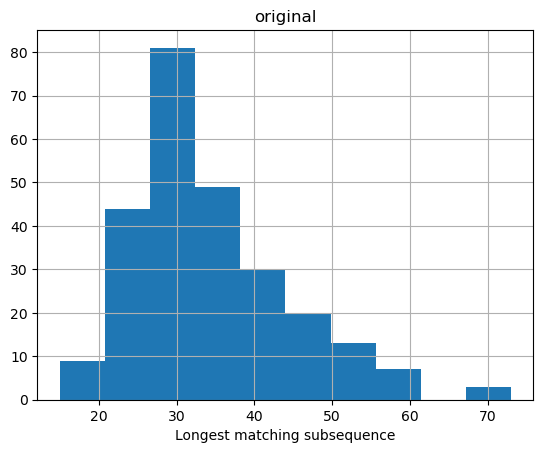

In [451]:
og_sim[og_sim[1]>0.01].rename({1: "original"}, axis=1).hist()
plt.xlabel("Longest matching subsequence")

Text(0.5, 0, 'Longest matching subsequence')

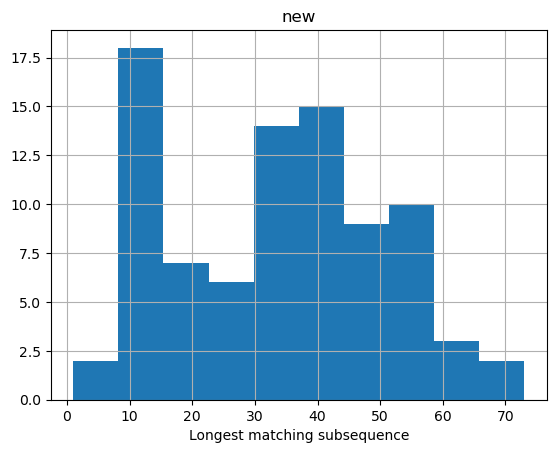

In [452]:
new_sim[new_sim[1]>0.01].rename({1: "new"}, axis=1).hist()
plt.xlabel("Longest matching subsequence")

Text(0.5, 0, 'Jaccard')

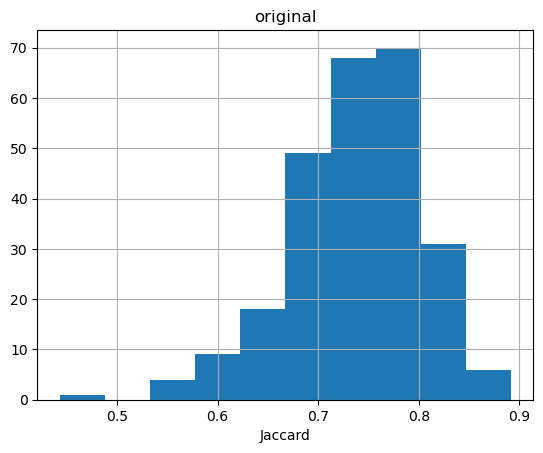

In [453]:
og_j[og_j[1]>0.01].rename({1: "original"}, axis=1).hist()
plt.xlabel("Jaccard")

Text(0.5, 0, 'Jaccard')

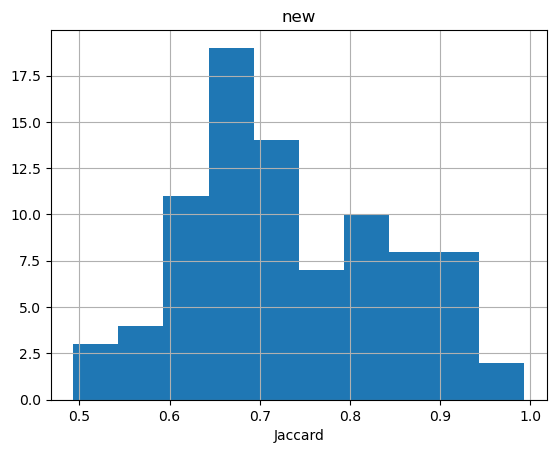

In [454]:
new_j[new_j[1]>0.01].rename({1: "new"}, axis=1).hist()
plt.xlabel("Jaccard")